# <B> Mayo Clinic - STRIP AI</B>

![](https://cdn.pixabay.com/photo/2022/04/08/01/01/blood-clot-7118517_960_720.png)

## <u>EDA and basic image manipulation</u>

**Organiser:** The Mayo Clinic is a nonprofit American academic medical center focused on integrated health care, education, and research. It employs over 4,500 physicians and scientists, along with another 58,400 administrative and allied health staff, across three major campuses:
* Rochester, Minnesota
* Jacksonville, Florida
* Phoenix/Scottsdale, Arizona.
The practise specializes in treating difficult cases through tertiary care and destination medicine. It spends over 660 million dollars a year on research and has more than 3,000 full-time research personnel
Competition's sponsor webpage: https://www.mayoclinic.org/

**Competition overview:**
* Type of problem: Classification
* Target: binary
* Subject: blood clots 

What are the blook clots you can read [here](https://www.hematology.org/education/patients/blood-clots).

In this notebook I'll show you how to open .tiff files in a couple of ways using following libraries:
* PIL
* Matplotlib
* CV2
* Scikit-image
* OpenSlide  

You can then choose the one the most convenient for you. First, we'll load and explore the original set and later we'll attach to the notebook a sliced version of the database prepared by Rob Mula (https://www.kaggle.com/robikscube). Additionally, we'll perform here an Exploratory Data Analysis.

[](http://)

## Importing libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from glob import glob
from pprint import pprint
from collections import defaultdict
import gc

# 1. Images metadata  

In this section we'll explore tabular data related to the provided images.

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
other_df = pd.read_csv('../input/mayo-clinic-strip-ai/other.csv')

In [3]:
train_df.head()

image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE

In [4]:
test_df.head()

image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0
3  01adc5_0         11     01adc5          0

In [5]:
other_df.head()

image_id patient_id  image_num  other_specified    label
0  01f2b3_0     01f2b3          0              NaN  Unknown
1  01f2b3_1     01f2b3          1              NaN  Unknown
2  02ebd5_0     02ebd5          0              NaN  Unknown
3  0412ab_0     0412ab          0              NaN  Unknown
4  04414e_0     04414e          0  Hypercoagulable    Other

Let's check number of unique patitiens in each dataset.

In [6]:
patients_train = train_df['patient_id'].nunique()
patients_test = test_df['patient_id'].nunique()
patients_other = other_df['patient_id'].nunique()

print(f"Number of unique patients in train set: {patients_train}")
print(f"Number of unique patients in test set: {patients_test}")
print(f"Number of unique patients in the 'other' set: {patients_other}")

Number of unique patients in train set: 632
Number of unique patients in test set: 4
Number of unique patients in the 'other' set: 336


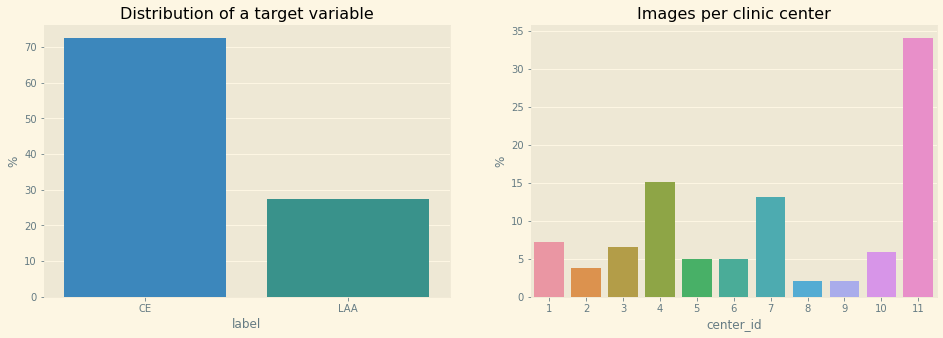

In [7]:
plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

In [8]:
print("Other types of blood clots not a part of this competition:")
print(list(other_df['other_specified'].unique()))

Other types of blood clots not a part of this competition:
[nan, 'Hypercoagulable', 'Dissection', 'Catheter', 'Stent thrombosis', 'PFO', 'Trauma', 'Takayasu vasculitis', 'tumor embolization', 'Endocarditis']


# 2. Images - exploration and processing  

First let's see how many images do we have to deal with.

In [9]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


## 2.1 Getting images' statistics using OpenSlide package

OpenSlide is a library created for reading high-resolution pictures used in digital pathology. It has a couple of practical features used when dealing with these specific heavy images.  
Docs: https://openslide.org/api/python/

In [10]:
from openslide import OpenSlide

In [11]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train_df, on='image_id')
image_data.head()

image_id  width  height     size  \
0  006388_0  34007   60797  1312.94   
1  008e5c_0   5946   29694   109.57   
2  00c058_0  15255   61801   351.76   
3  01adc5_0  55831   26553   679.17   
4  026c97_0  10533    8267    61.21   

                                                path  img_aspect_ratio  \
0  /kaggle/input/mayo-clinic-strip-ai/train/00638...          0.559353   
1  /kaggle/input/mayo-clinic-strip-ai/train/008e5...          0.200242   
2  /kaggle/input/mayo-clinic-strip-ai/train/00c05...          0.246841   
3  /kaggle/input/mayo-clinic-strip-ai/train/01adc...          2.102625   
4  /kaggle/input/mayo-clinic-strip-ai/train/026c9...          1.274102   

   center_id patient_id  image_num label  
0         11     006388          0    CE  
1         11     008e5c          0    CE  
2         11     00c058          0   LAA  
3         11     01adc5          0   LAA  
4          4     026c97          0    CE

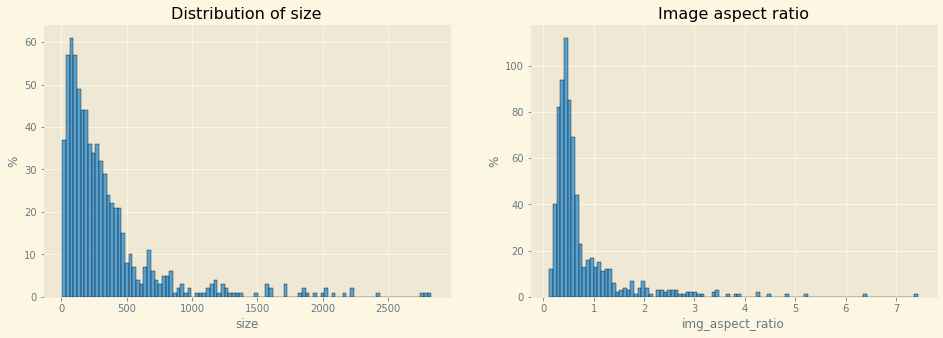

In [12]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

## 2.2 Displaying images

In this section we'll display couple of images and perform basic image manipulation.

## 2.2.1 Displaying random images using PIL  

PIL stands for *Python Imaging Library* and is one of the most popular python libraries for image opening and processing (known also as *pillow*). Let's open with it couple of random images. In order not to kill out RAM, for a quick look we can use PIL function `thumbnail()`.

In [13]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # you have to set this value to allow displaying high-resolution images

In [14]:
CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']

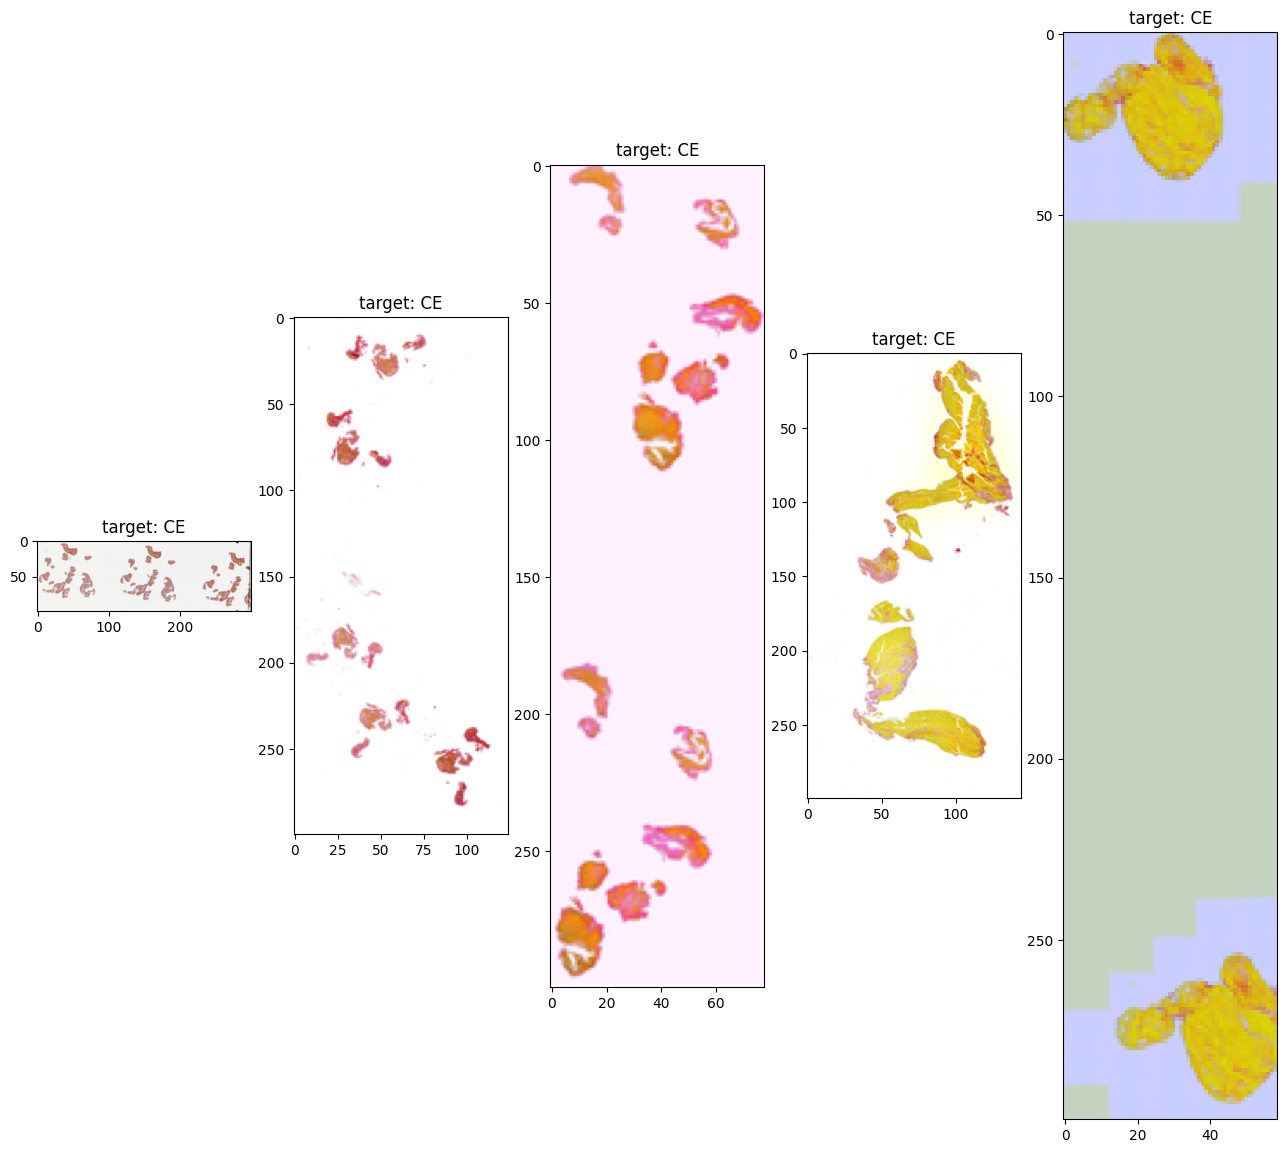

In [15]:
plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

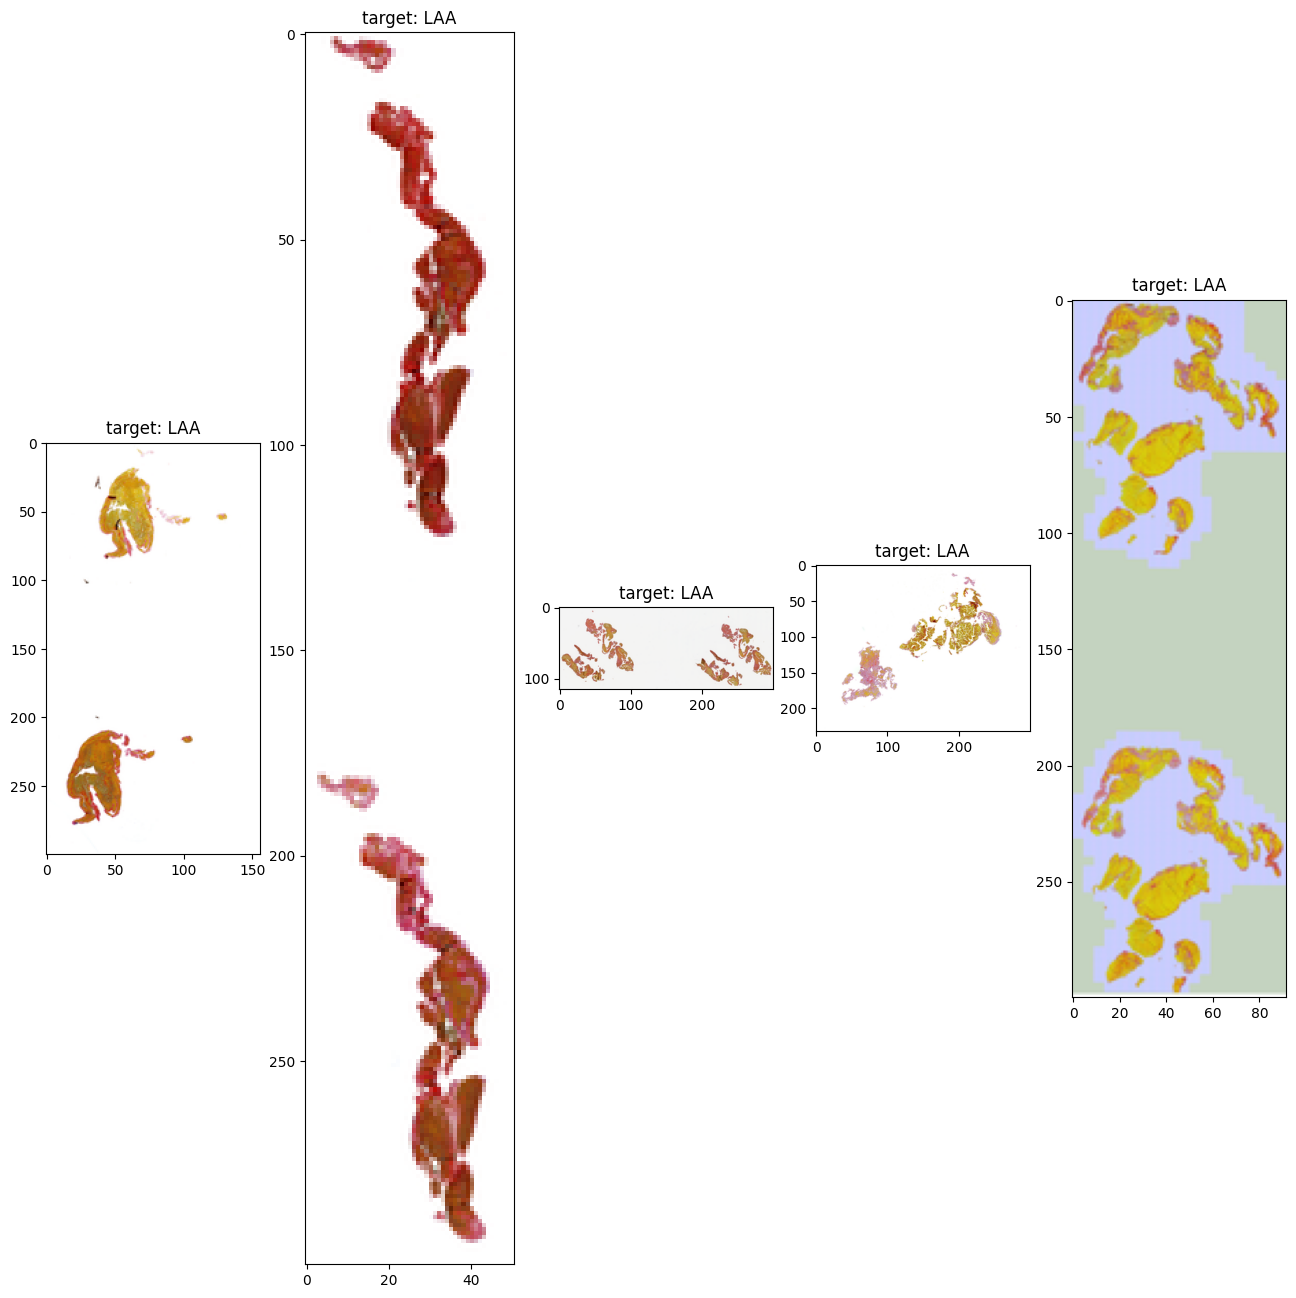

In [16]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

In [17]:
type(img)

PIL.TiffImagePlugin.TiffImageFile

Note that PIL stores an image as a PIL object. This is different to CV2 and skimage which store images as numpy arrays - what eases significantly the postprocessing.

**First impressions:**
1. Images sizes are from small ones to a high-resolution ones
2. Images have different aspect ratios
3. A significant amount of images is a background
4. Backgrounds have different colours
5. Cloths are usually in the form of multiple small pieces
6. Blood cloths have different colours

Let's look at the biggest image metadata. Also, if you try to open it using PIL, CV2 or Matplotlib without scaling, on a standard Kaggle notebook you'll run out of memory.

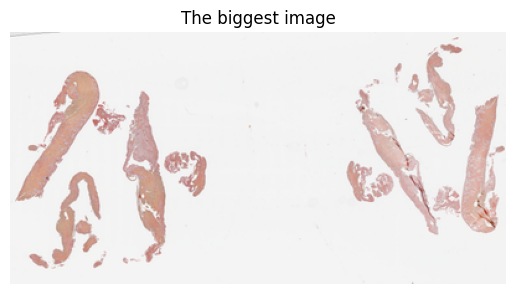

In [18]:
biggest_img_path = image_data.iloc[image_data["size"].idxmax(),:]['path']

img = Image.open(biggest_img_path)
img.thumbnail((400,400), Image.Resampling.LANCZOS)
plt.title("The biggest image")
plt.imshow(img)
plt.axis('off'); plt.show()
del img

Now let's look at 3 smallest images. I'll use here, for demonstration, matplotlib library. Documentation and tutorial regarding image reading is [here](https://matplotlib.org/stable/tutorials/introductory/images.html).

In [19]:
smallest_3img_data = image_data.sort_values(by="size")[:3]
smallest_3img_paths = smallest_3img_data['path'].values

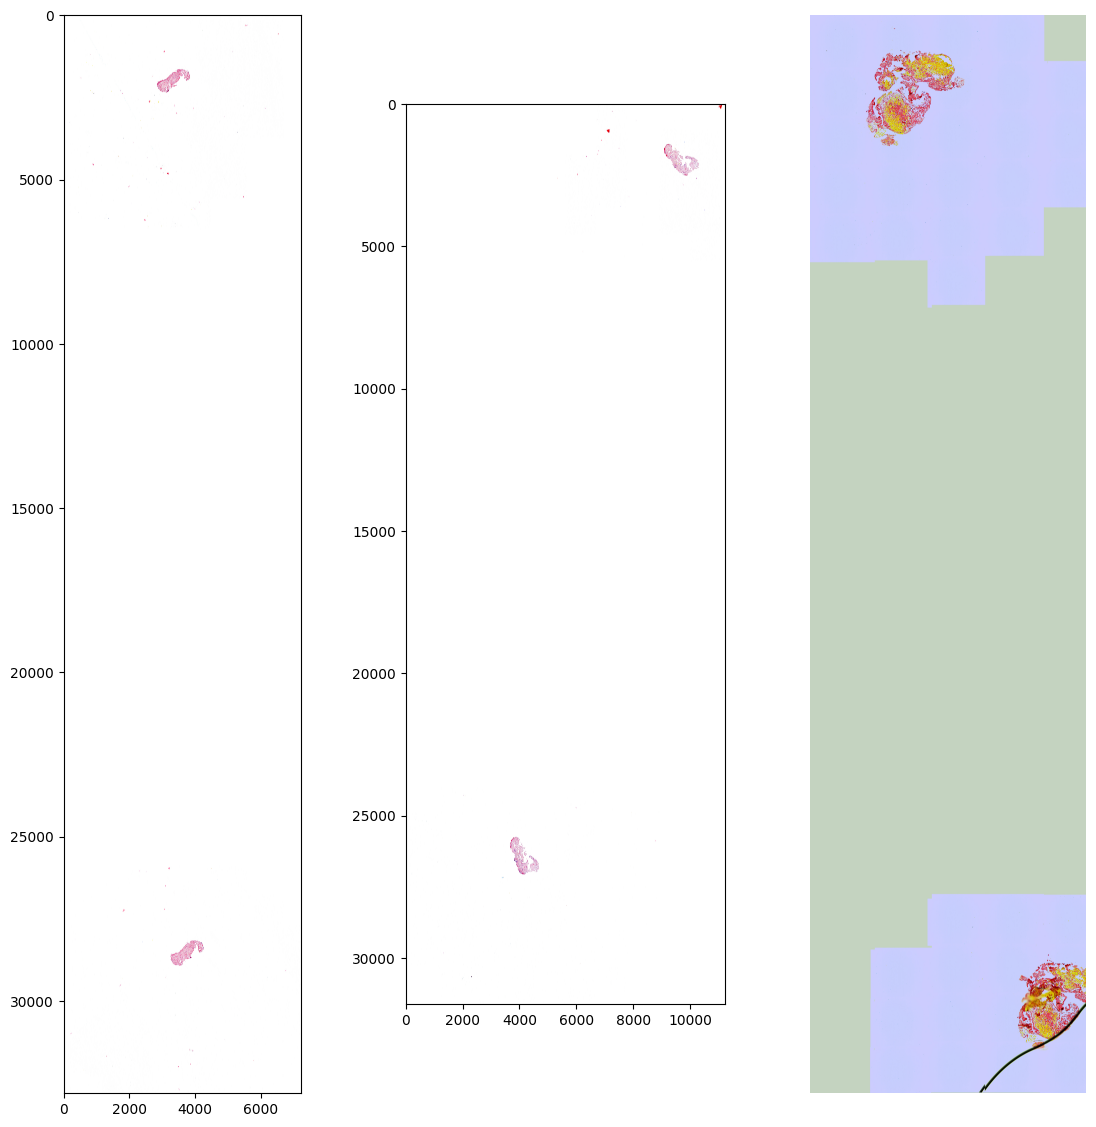

In [20]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(1,3, figsize=(14,14))
for i, ax in enumerate(axes.reshape(-1)):
    img = mpimg.imread(smallest_3img_paths[i])   
    ax.imshow(img), plt.axis('off')
plt.show()

## 2.2.2 Displaying, resizing and manipulation using CV2 and skimage

Here we're going to open the full image using *Computer Vision* library CV2. We can use this library also for image manipulations what I'll show you as well. You can also detect edges bu using the Canny edge detector.  
NOTE: CV2 library has an image size limit and will give you an error with some of the images from our dataset. There's a workaround by changing the environmental variable (see section 0) but even then some images will not fit into memory. That's why we are going also to use an other library later.

We can manipulate this image in couple of ways. For this I've chosen an exemplary image.

In [21]:
img_path = train_images[261]
img_name = img_path[-12:-4]
sel_img = image_data[image_data['image_id']==img_name]
sel_img

image_id  width  height   size  \
498  a9c427_0  14368   16628  91.85   

                                                  path  img_aspect_ratio  \
498  /kaggle/input/mayo-clinic-strip-ai/train/a9c42...          0.864085   

     center_id patient_id  image_num label  
498          5     a9c427          0    CE

Let's look how does it look using matplotlib (why not CV2? you'll find something peculiar about CV2 later).

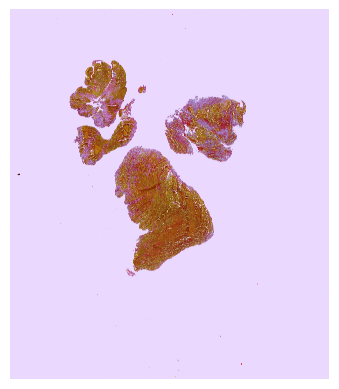

In [22]:
img = mpimg.imread(img_path)   
plt.imshow(img), plt.axis('off')
plt.show()

 Now I'll read this image in CV2 and I'll rescale it. The size will be reduces to 10% of the original scale - you can confirm it works by looking at the right axes or simply plotting a shape of a second image.

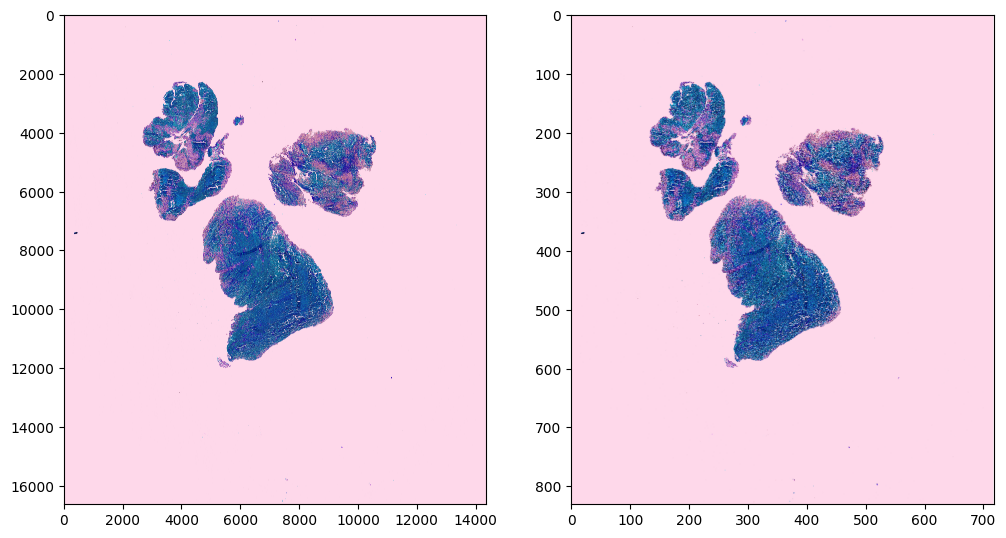

In [23]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
image_resized = cv2.resize(img, (0,0), fx=0.05, fy=0.05)

fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img)
ax[1].imshow(image_resized)
plt.show()

In order to open it in RGB we have to do the following operation:

In [24]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

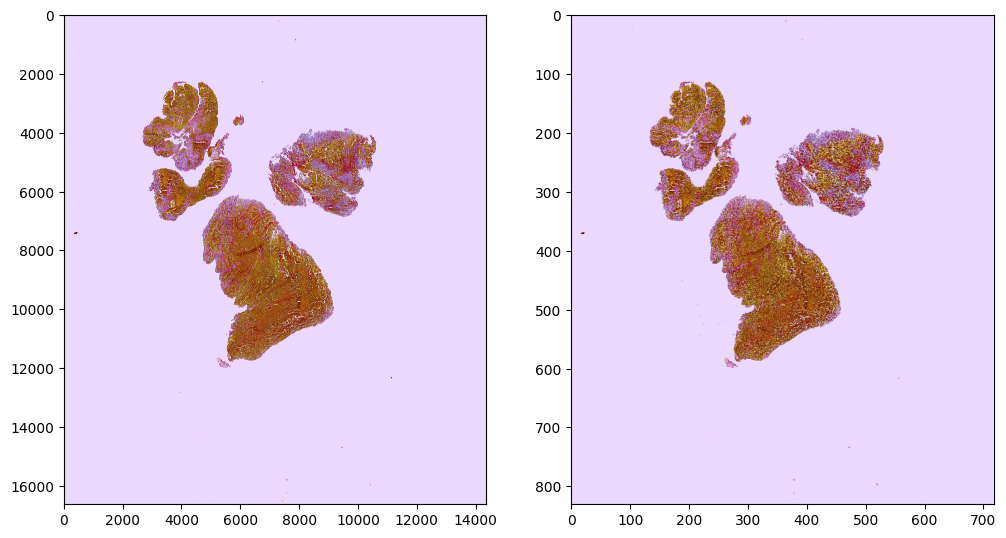

In [25]:
image_resized = cv2.resize(img, (0,0), fx=0.05, fy=0.05)

fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img)
ax[1].imshow(image_resized)
plt.show()

You may notice later that images opened in CV2 have different colors than the ones opened in other libraries. This is because CV2 by defoult reads color channgels as BGR (blue-gree-red) not RGB.

In [26]:
print(f"Type of CV2 image: {type(img)}")
print(f"Memory occupied by CV2 image: {sys.getsizeof(img)/1e6:.2f}MB")
print(f"Memory occupied by reduced CV2 image: {sys.getsizeof(image_resized)/1e6:.2f}MB")
print(f'A shape of a resized image: ({image_resized.shape[0]}, {image_resized.shape[1]}). Number of color channels: {image_resized.shape[2]}')

Type of CV2 image: <class 'numpy.ndarray'>
Memory occupied by CV2 image: 716.73MB
Memory occupied by reduced CV2 image: 1.79MB
A shape of a resized image: (831, 718). Number of color channels: 3


Note that CV2 stores image as a numpy array. 

Below are 3 exemplary transformations using CV2:
* Increasing contract. For this we have to use `addWeighted` function
* Detecting edges. For this we use Canny method.
* Reading in a grayscale. Here we use `cv2.COLOR_RGB2GRAY` and we tell `.imshow()` that we are passing a single gray channel.

In [27]:
contrast_img = cv2.addWeighted(image_resized, 2.5, np.zeros(image_resized.shape, image_resized.dtype), 0, 0)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

min_intensity_grad, max_intensity_grad = 100, 200
edge_img = cv2.Canny(image_resized, min_intensity_grad, max_intensity_grad)

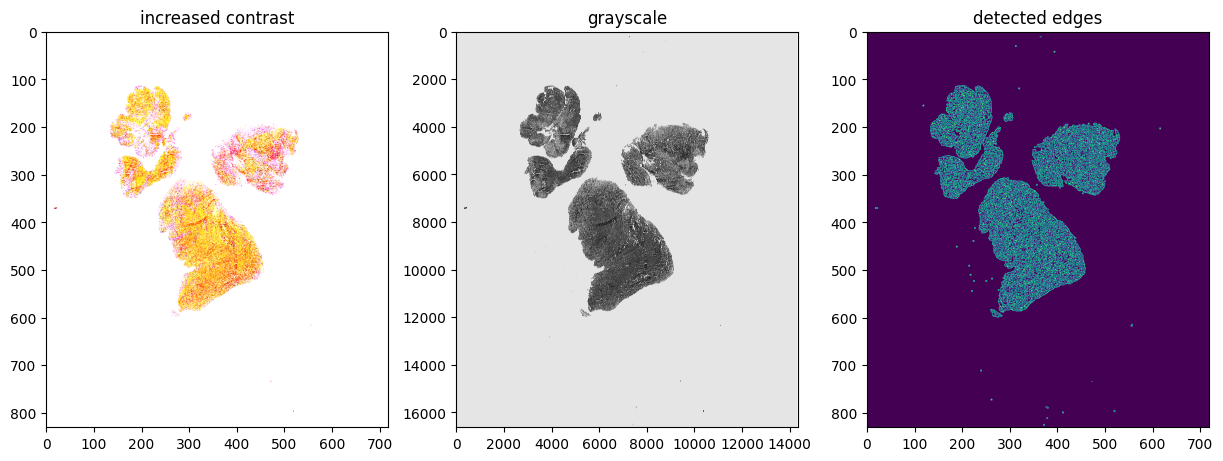

In [28]:
fig, ax = plt.subplots(1,3, figsize=(15,20))
ax[0].imshow(contrast_img); ax[0].set_title('increased contrast')
ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 255); ax[1].set_title('grayscale')
ax[2].imshow(edge_img); ax[2].set_title('detected edges')
plt.show()

In [29]:
gc.collect()
del contrast_img, edge_img, img_gray, image_resized

## 2.2.3 Transformations using scikit-image

Now the same transformations will be performed using Scikit-Image. This is an another popular python package containing set image processing funcions. Official page: https://scikit-image.org/ but the most interesting section is this: https://scikit-image.org/docs/stable/user_guide/transforming_image_data.html. Skimage stores images as numpy arrays.


In [30]:
from skimage import io, exposure, feature
from skimage.transform import rescale
from skimage.color import rgb2gray

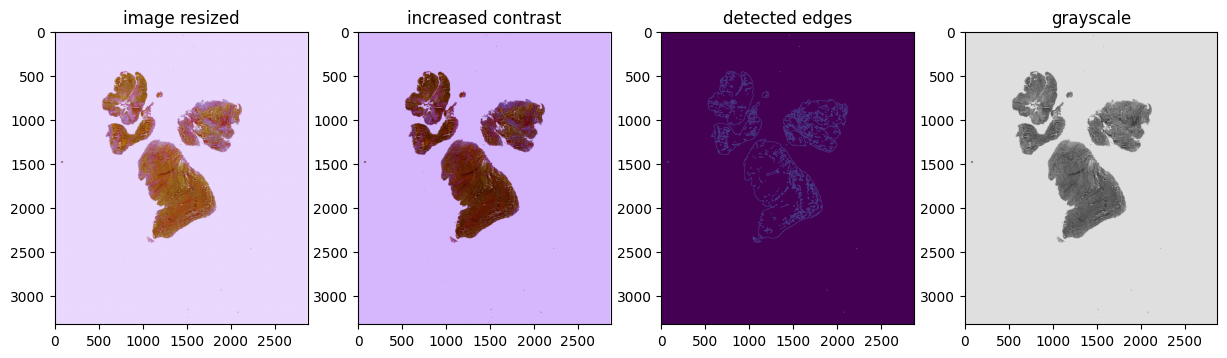

In [31]:
img = io.imread(img_path)
image_resized = rescale(img, 0.2, multichannel=True, anti_aliasing=True) # creating a scaled image
increased_contrast = exposure.adjust_gamma(image_resized, 2)
img_gray = rgb2gray(image_resized)
edge_img = feature.canny(img_gray, sigma=3) # canny works only with grayscale images

fig, ax = plt.subplots(1,4, figsize=(15,20))
ax[0].imshow(image_resized); ax[0].set_title('image resized')
ax[1].imshow(increased_contrast); ax[1].set_title('increased contrast')
ax[2].imshow(edge_img); ax[2].set_title('detected edges')
ax[3].imshow(img_gray, cmap='gray'); ax[3].set_title('grayscale')
plt.show()

## 2.2.4 Using OpenSlide

Here we're going to open a slide (image) and plot only a zoomed region. It is achieved by using `slide.read_region()` function. OpenSlide stores images in memory as Openslide objects.

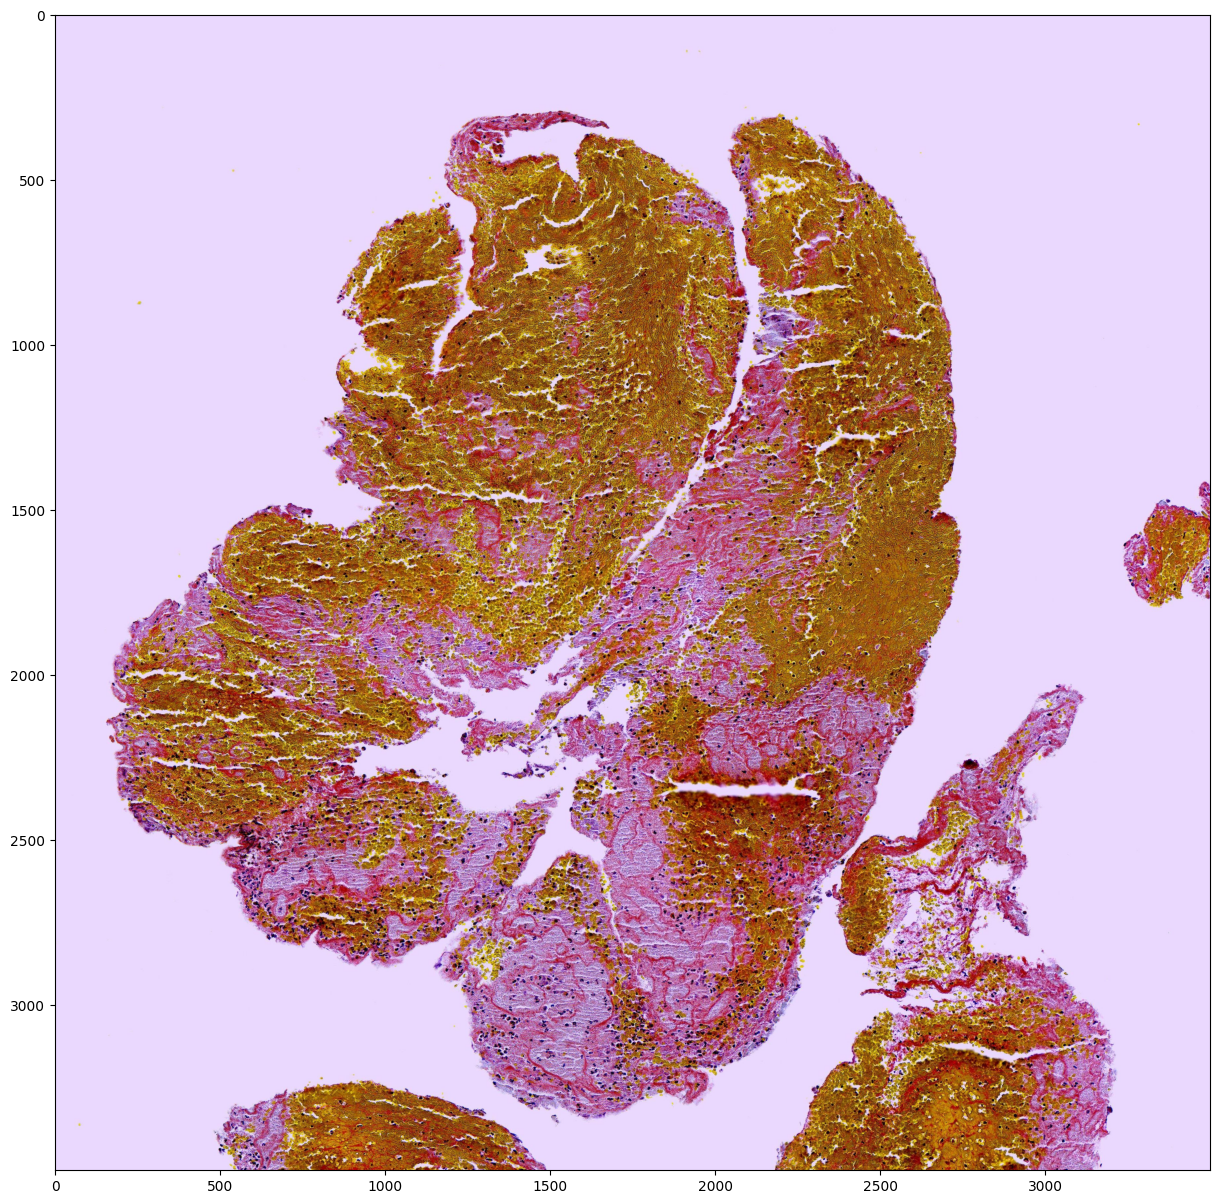

In [32]:
slide = OpenSlide(img_path) # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)

plt.figure(figsize=(15, 15))
plt.imshow(region)
plt.show()

What do we actually see here? I'm not a doctor so I'll use a picture from the wikipedia: 

<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Composition_of_a_fresh_thrombus.jpg" width="648" />

In [33]:
type(slide)

openslide.OpenSlide

# 3 Sliced version of the database

List od the datasets: https://www.kaggle.com/competitions/mayo-clinic-strip-ai/discussion/335755. In order to add thia database to the notebook you have to use "+ Add data" option in the upper right corner. I'm going to use skimage library here.

In [34]:
sliced_train_images = glob("../input/mayo-clinic-1024-jpg-part1/train/*")

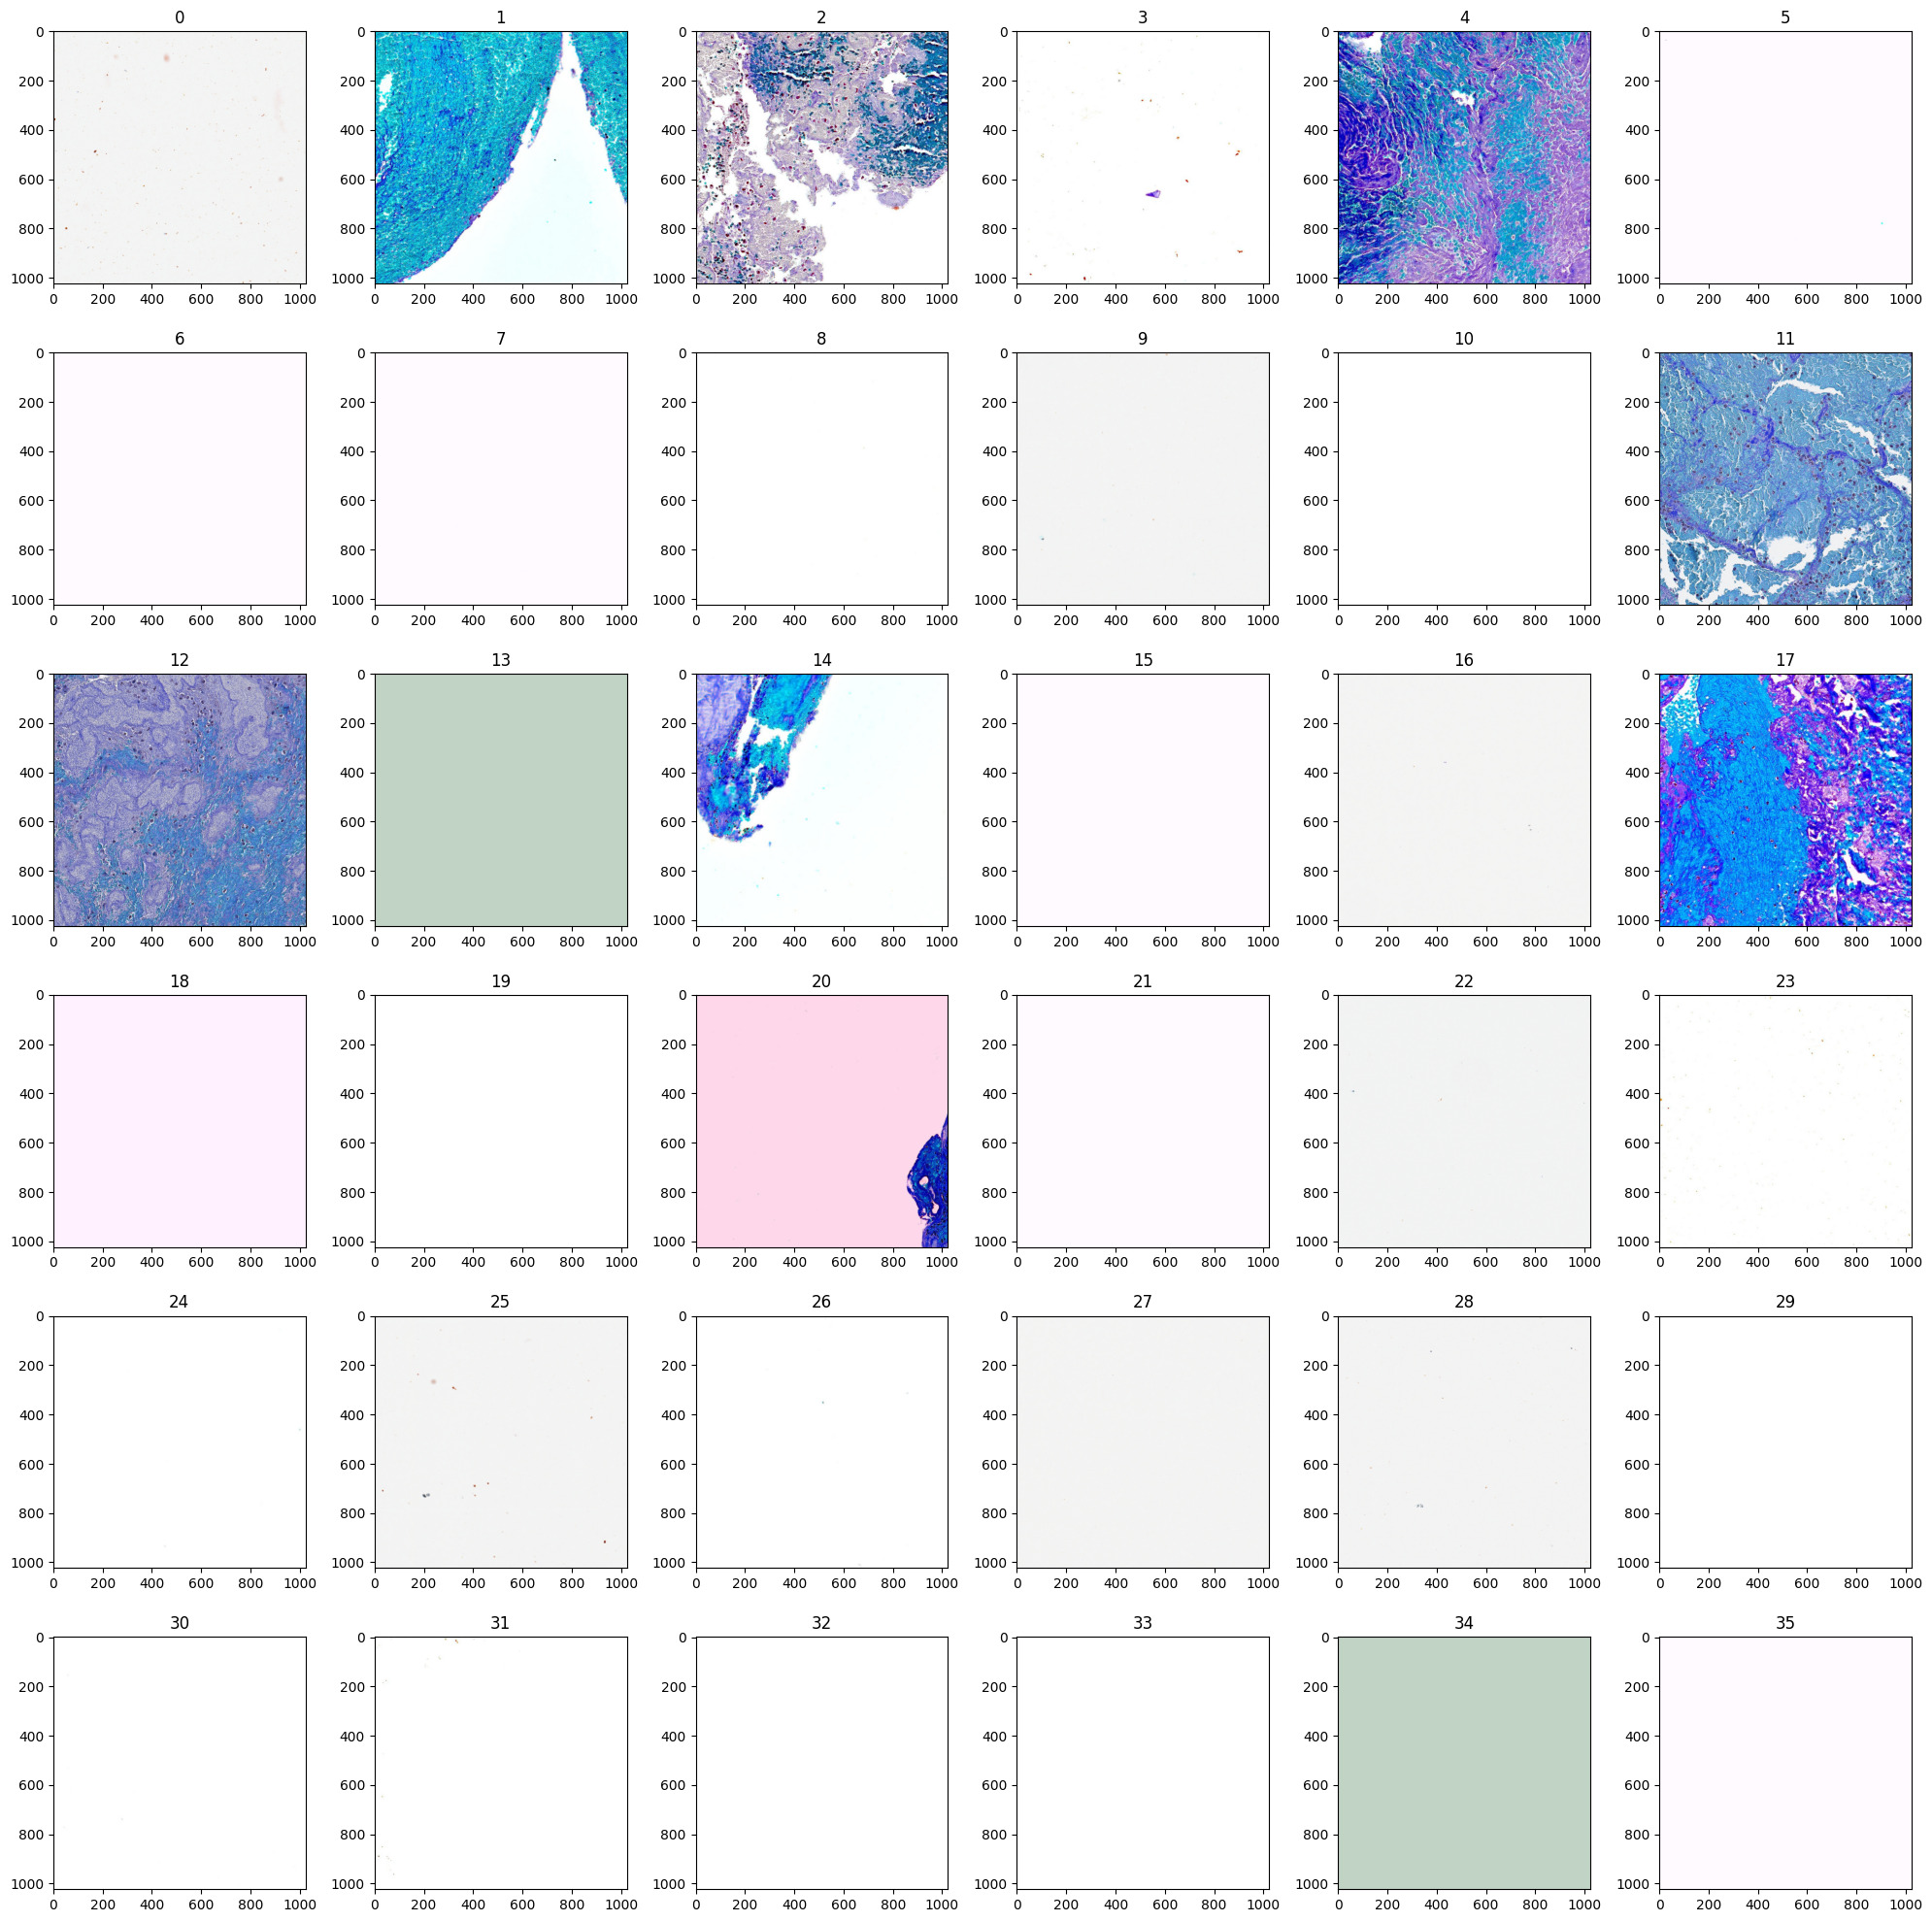

In [35]:
fig, axes = plt.subplots(6,6, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    img = io.imread(sliced_train_images[i])
    ax.imshow(img); ax.set_title(i)
plt.tight_layout()
plt.show()

As you can see a lot of these pictures contains just a background. Dealing with this problem will be another step to perform. Below some more detailed introduction into image processing using skimage. Stay tuned and if you liked what you've seen so far don't hesitate to upvote!

In [36]:
img_obj_ids = [1, 2, 4, 11, 12, 14]
img_bck_ids = [0, 3, 5, 6, 7, 8]

imgs_object = []
imgs_backgr = []

for i in img_obj_ids:
    imgs_object.append(io.imread(sliced_train_images[i]))
    
for i in img_bck_ids:
    imgs_backgr.append(io.imread(sliced_train_images[i]))

## Analysis of color channels
Each image has 3 color channels (RGB): Red, Green, Blue. Below I'll display these channels. As each channel represents only intensity of a given single color I'll display these images in a grayscale to avoid any confusion (by displayed colors otherwise).

NOTE: Values of each colour channel are in range from 0 to 255.

In [37]:
imgs_object[0].shape

(1024, 1024, 3)

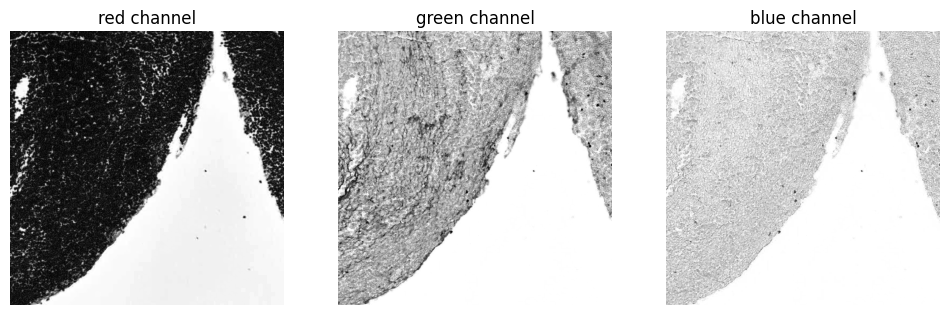

In [38]:
fig, axes = plt.subplots(1,3, figsize=(12,12))
colors = ['red', 'green', 'blue']
for i, ax in enumerate(axes):
    ax.imshow(imgs_object[0][:,:,i], cmap='gray')
    ax.set_title(colors[i]+' channel'), ax.axis('off')
plt.show()

In [39]:
img_obj = imgs_object[0]
img_bck = imgs_backgr[0]

img_obj_channels = [img_obj[0], img_obj[1], img_obj[2]]
img_bck_channels = [img_bck[0], img_bck[1], img_bck[2]]

Images in skimage are stored as Numpy arrays and all Numpy functions can be applied to it.

In [40]:
# 1024*1024
type(img_obj_channels[0])

numpy.ndarray

In [41]:
print("Images with objects")
for i, channel in enumerate(img_obj_channels):
    print(f"Channel {i} values: min: {channel.min()}, max: {channel.max()}, average: {channel.mean()}, std: {channel.std()}")

Images with objects
Channel 0 values: min: 0, max: 255, average: 145.84342447916666, std: 86.37888861387819
Channel 1 values: min: 0, max: 255, average: 144.72591145833334, std: 86.36559135595029
Channel 2 values: min: 0, max: 255, average: 144.16764322916666, std: 86.7266243867392


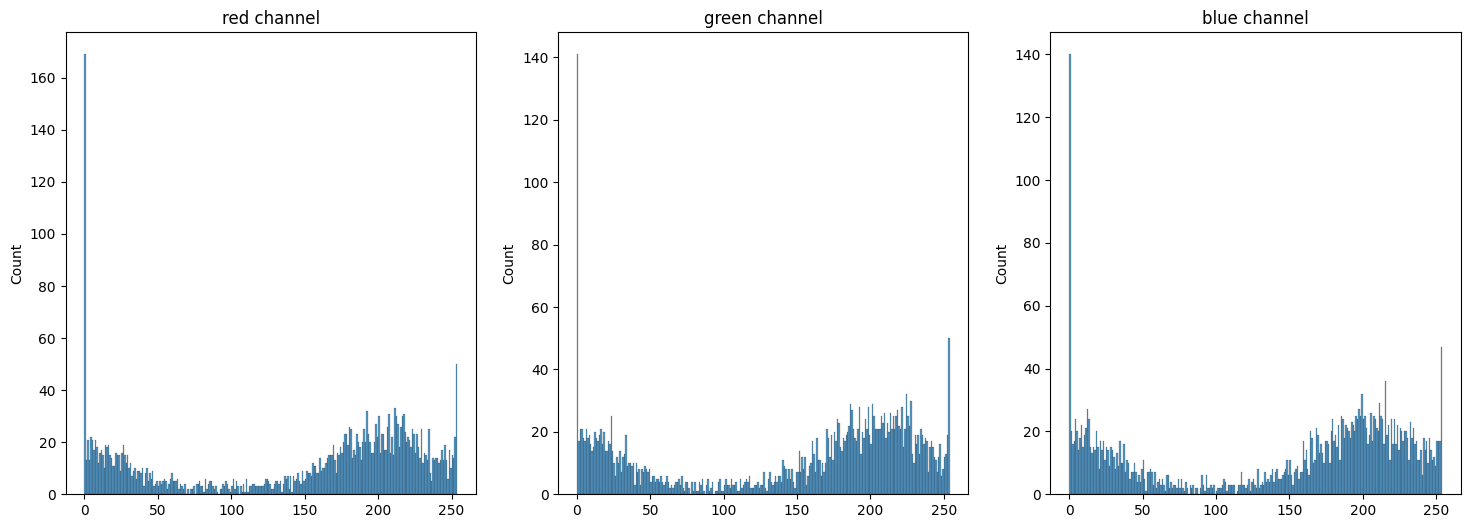

In [42]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
for i, ax in enumerate(axes):
    df = img_obj_channels[i].ravel()
    sns.histplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(colors[i]+' channel')
plt.show()

In [43]:
print("Images with background only")
for i, channel in enumerate(img_bck_channels):
    print(f"Channel {i} values: min: {channel.min()}, max: {channel.max()}, average: {channel.mean()}")

Images with background only
Channel 0 values: min: 109, max: 255, average: 243.07389322916666
Channel 1 values: min: 62, max: 253, average: 242.84765625
Channel 2 values: min: 70, max: 255, average: 242.92317708333334


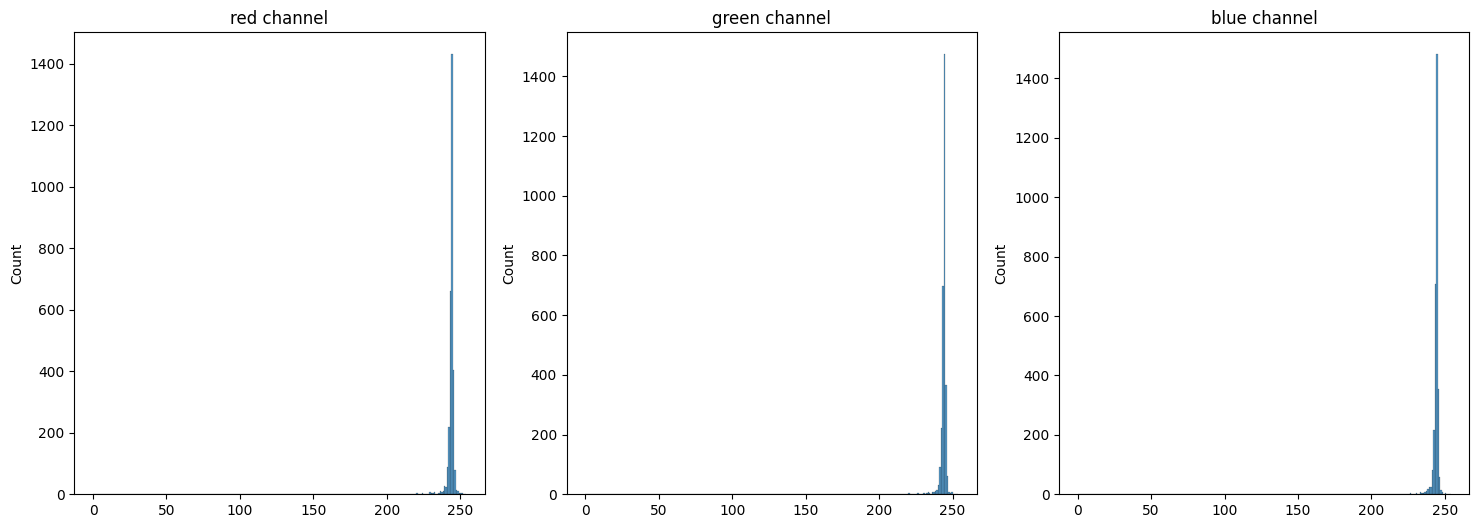

In [44]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
for i, ax in enumerate(axes):
    df = img_bck_channels[i].ravel()
    sns.histplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(colors[i]+' channel')
plt.show()

centers.plot.bar(rot=0)
plt.show()Assuming that images with object have a wide range of values (high std. error) in color channels and background ones have a narrow, this property can be used to distinguish images between them. Also we don't have to use 3 color channels - as we see the difference is significant in all three channels. So reading images in grayscale should do the work as well.

NOTE: When working with grayscale images each pixel is now a value of intensity only, which is in range from 0 to 1. 

In [45]:
imgs_object = []
imgs_backgr = []

for i in img_obj_ids:
    img = io.imread(sliced_train_images[i])
    imgs_object.append(rgb2gray(img))
    
for i in img_bck_ids:
    img = io.imread(sliced_train_images[i])
    imgs_backgr.append(rgb2gray(img))

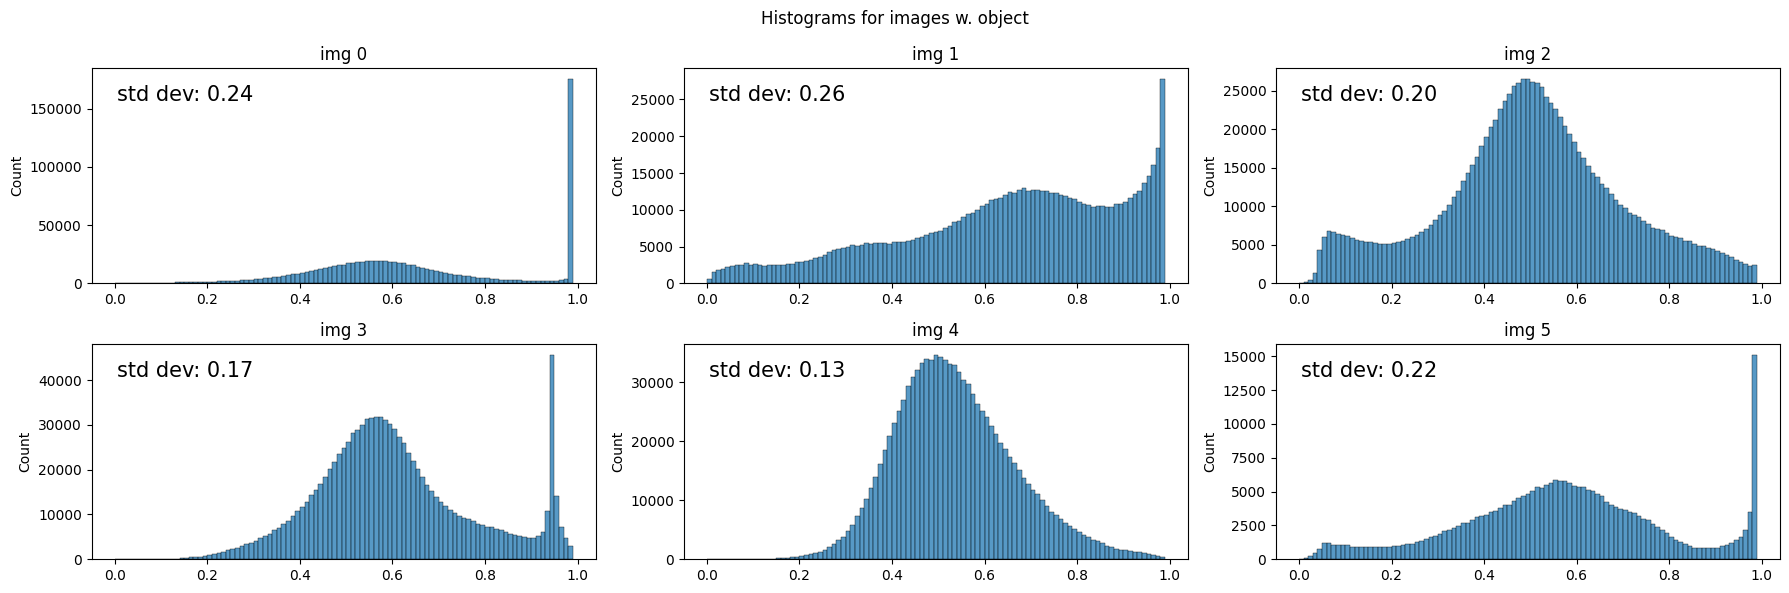

In [46]:
std_dev_obj = []
fig, axes = plt.subplots(2,3, figsize=(18,6))
for i, ax in enumerate(axes.flat):
    img_matrix = imgs_object[i].ravel()
    std_dev = np.std(img_matrix)
    std_dev_obj.append(std_dev)
    sns.histplot(img_matrix, bins=np.arange(0,1, 0.01), ax=ax)
    ax.text(0.05,0.85, f'std dev: {std_dev:.2f}', size=15, transform = ax.transAxes)
    ax.set_title(f'img {i}') 
plt.suptitle('Histograms for images w. object')
plt.tight_layout()
plt.show()

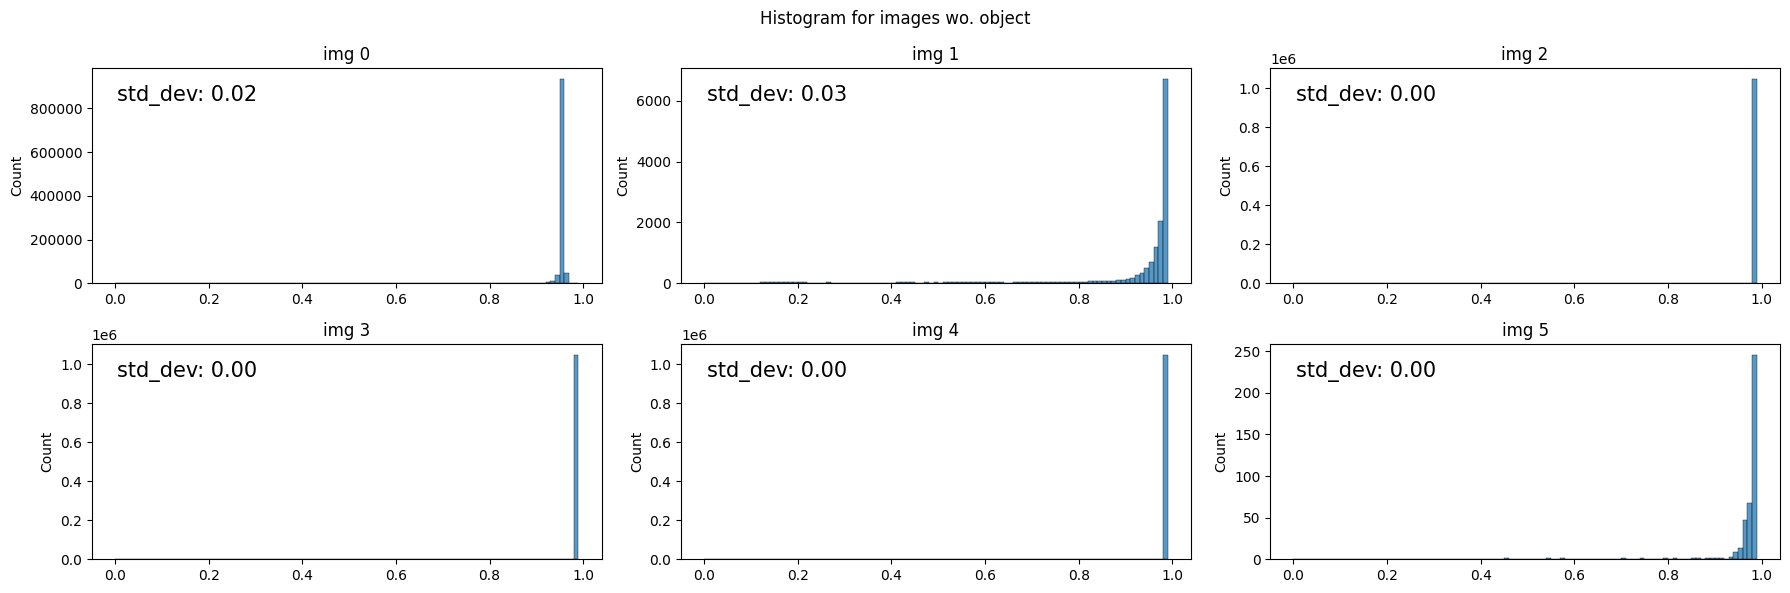

In [47]:
fig, axes = plt.subplots(2,3, figsize=(18,6))
for i, ax in enumerate(axes.flat):
    img_matrix = imgs_backgr[i].ravel()
    std_dev = np.std(img_matrix)
    std_dev_obj.append(std_dev)
    sns.histplot(img_matrix, bins=np.arange(0,1, 0.01), ax=ax)
    ax.text(0.05,0.85, f'std_dev: {std_dev:.2f}', size=15, transform = ax.transAxes)
    ax.set_title(f'img {i}')  
plt.suptitle('Histogram for images wo. object')
plt.tight_layout()
plt.show()